## Code Discussion 6
### Zixun Hao zh210

Building off what we did in lecture this week, please build a model that predicts the log selling price of a house in DC (PRICE). Please use what you've learned of the sklearn library to accomplish this task.

I've split this dataset into a training and test dataset (so you don't need to split it on your own). Using the training data, build a model that predicts the price of a residential unit in District of Columbia.

You may use any feature in the dataset to generate a model. Some things to keep in mind:

- Be sure to predict the log Price, not the raw Price
- Be sure to pre-process your data.
- Be careful of missing data values. You can do whatever you like with them.
- Try different models, some algorithms perform better on a specific data outcome than others.
- Be sure to tune your model (if it has relevant tuning parameters).
- Once you've come up with a model that you think performs well, please test your model on the provided test data and report the mean squared error.

### Import packages and data

In [82]:
# Data Management/Investigation
import pandas as pd
import numpy as np
import missingno as miss
from plotnine import *
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# For pre-processing data 
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods 
from sklearn.linear_model import LinearRegression as LM
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.tree import DecisionTreeRegressor as DTree
from sklearn import tree # For plotting the decision tree rules
from sklearn.ensemble import BaggingRegressor as Bag
from sklearn.ensemble import RandomForestRegressor as RF

# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

In [83]:
# read in the training and test data
train = pd.read_csv("../train_data.csv")
test = pd.read_csv("../test_data.csv")
print(train.shape)
# check out all of the columns in the dataset
train.columns

(43590, 39)


Index(['OBJECTID', 'SSL', 'BATHRM', 'HF_BATHRM', 'HEAT', 'HEAT_D', 'AC',
       'NUM_UNITS', 'ROOMS', 'BEDRM', 'AYB', 'YR_RMDL', 'EYB', 'STORIES',
       'SALEDATE', 'QUALIFIED', 'SALE_NUM', 'GBA', 'BLDG_NUM', 'STYLE',
       'STYLE_D', 'STRUCT', 'STRUCT_D', 'GRADE', 'GRADE_D', 'CNDTN', 'CNDTN_D',
       'EXTWALL', 'EXTWALL_D', 'ROOF', 'ROOF_D', 'INTWALL', 'INTWALL_D',
       'KITCHENS', 'FIREPLACES', 'USECODE', 'LANDAREA', 'GIS_LAST_MOD_DTTM',
       'LN_PRICE'],
      dtype='object')

### Inspect data, check for potential outliers, remove outliers

In [84]:
# check out the training data set
train.head (5)

,OBJECTID,SSL,BATHRM,HF_BATHRM,HEAT,HEAT_D,AC,NUM_UNITS,ROOMS,BEDRM,...,ROOF,ROOF_D,INTWALL,INTWALL_D,KITCHENS,FIREPLACES,USECODE,LANDAREA,GIS_LAST_MOD_DTTM,LN_PRICE
0,78021,4061N 0085,3.0,1.0,1.0,Forced Air,Y,1.0,9.0,4.0,...,2.0,Built Up,6.0,Hardwood,1.0,0.0,11,2234,2018-07-22T18:01:43.000Z,13.591116
1,28783,1587 0075,2.0,1.0,7.0,Warm Cool,Y,1.0,7.0,3.0,...,11.0,Slate,6.0,Hardwood,1.0,1.0,12,3850,2018-07-22T18:01:43.000Z,12.730801
2,35035,2024 0817,2.0,2.0,13.0,Hot Water Rad,Y,1.0,9.0,4.0,...,11.0,Slate,6.0,Hardwood,1.0,1.0,12,7866,2018-07-22T18:01:43.000Z,13.651814
3,67983,3736 0059,1.0,1.0,7.0,Warm Cool,Y,1.0,6.0,3.0,...,2.0,Built Up,6.0,Hardwood,1.0,0.0,13,2739,2018-07-22T18:01:43.000Z,12.860999
4,8791,0817 0826,2.0,0.0,13.0,Hot Water Rad,N,1.0,11.0,4.0,...,6.0,Metal- Sms,6.0,Hardwood,1.0,0.0,11,2097,2018-07-22T18:01:43.000Z,14.100690


We observe that there are both numeric and categorical variables in the data set. Let's inspect the numeric variables.

In [85]:
# conbine the training and test data set
train_test = pd.concat([train, test])
# the year of most recent sale is something we want to consider later as a predictor, we seperate it into a column
train_test['SALEYear'] = pd.to_datetime(train_test["SALEDATE"]).dt.year

# only extract numeric variable (exept ObjectID column)
numeric = train_test.select_dtypes(include = ['float64', 'int64']).iloc[:,1:]
numeric.describe()

,BATHRM,HF_BATHRM,HEAT,NUM_UNITS,ROOMS,BEDRM,AYB,YR_RMDL,EYB,STORIES,...,CNDTN,EXTWALL,ROOF,INTWALL,KITCHENS,FIREPLACES,USECODE,LANDAREA,LN_PRICE,SALEYear
count,58120.000000,58119.000000,58120.000000,58120.000000,58108.000000,58117.000000,58116.000000,33336.000000,58121.000000,58085.000000,...,58120.000000,58120.000000,58120.000000,58120.000000,58119.000000,58119.000000,58121.000000,58121.000000,58121.000000,58121.000000
mean,2.204026,0.649495,6.847626,1.221576,7.429459,3.429220,1931.482845,2004.261429,1969.791710,2.124879,...,3.708138,13.447350,3.963094,6.297109,1.251415,0.641116,13.277937,3171.446155,12.928077,2008.907262
std,1.067458,0.607217,5.149936,0.624942,2.370431,1.199319,83.097709,16.629371,16.934042,3.941666,...,0.746899,4.033265,3.332154,2.093512,0.662110,0.909725,4.178889,3145.140487,0.864354,7.014215
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,1900.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.000000,0.000000,0.000000,1900.000000
25%,1.000000,0.000000,1.000000,1.000000,6.000000,3.000000,1913.000000,2002.000000,1957.000000,2.000000,...,3.000000,14.000000,1.000000,6.000000,1.000000,0.000000,11.000000,1520.000000,12.388394,2004.000000
50%,2.000000,1.000000,7.000000,1.000000,7.000000,3.000000,1929.000000,2008.000000,1967.000000,2.000000,...,4.000000,14.000000,2.000000,6.000000,1.000000,0.000000,12.000000,2214.000000,12.994530,2010.000000
75%,3.000000,1.000000,13.000000,1.000000,8.000000,4.000000,1947.000000,2013.000000,1975.000000,2.000000,...,4.000000,14.000000,6.000000,6.000000,1.000000,1.000000,13.000000,4000.000000,13.527828,2015.000000
max,24.000000,11.000000,13.000000,6.000000,101.000000,54.000000,2018.000000,2019.000000,2018.000000,826.000000,...,6.000000,24.000000,15.000000,11.000000,44.000000,13.000000,39.000000,187301.000000,17.038378,2018.000000


We observe that there are outliers in many variables, including numbers of rooms, bathrooms, half bathrooms, units, bedrooms, stories, kitchens, fireplaces, and grade and landarea.

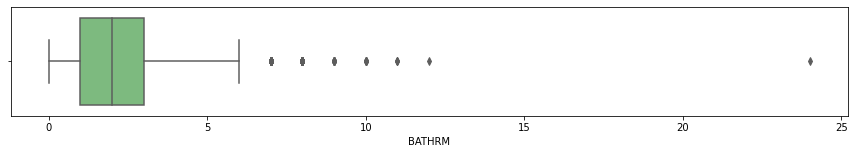

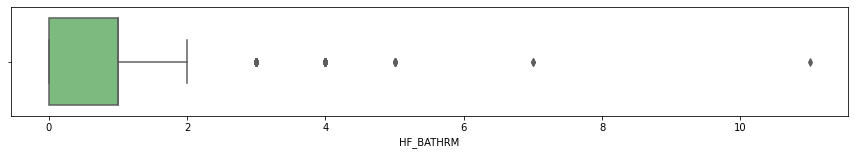

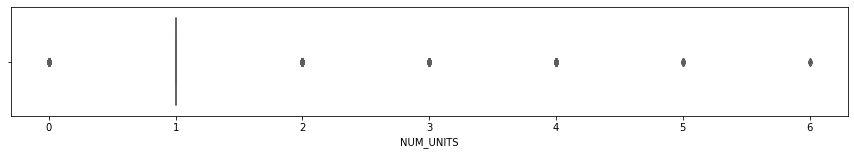

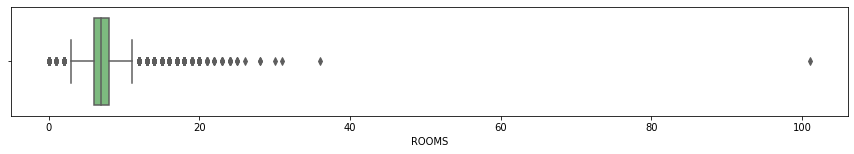

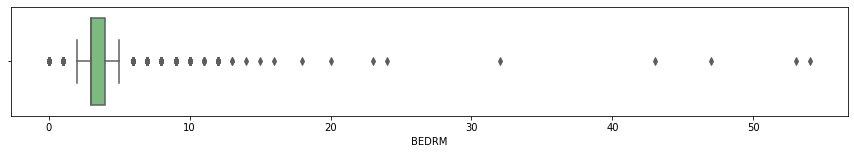

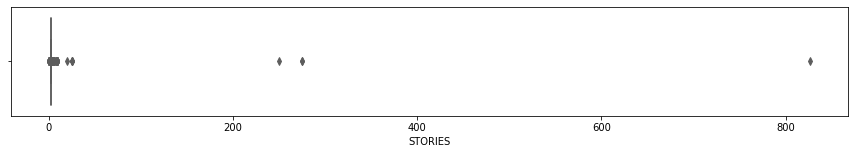

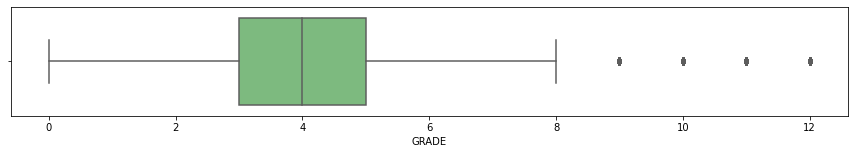

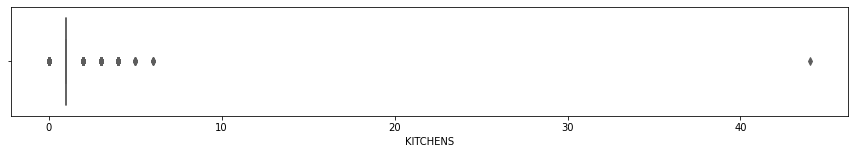

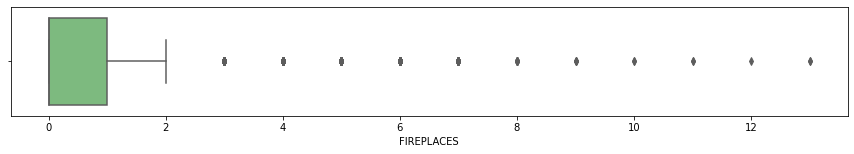

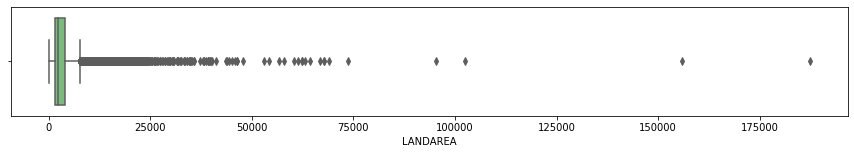

In [86]:
vars_with_outliers = ["BATHRM", "HF_BATHRM", "NUM_UNITS", "ROOMS", "BEDRM", "STORIES", "GRADE", "KITCHENS", "FIREPLACES", "LANDAREA"]
# plot numberic variables in boxplot to observe distribution of data
for i in vars_with_outliers:
    plt.figure(figsize=(15,2))
    sns.boxplot(x=numeric[i], palette="Greens")

In [87]:
rows_with_outliers = numeric.filter(items=["BATHRM", "HF_BATHRM", "NUM_UNITS", "ROOMS", "BEDRM", "STORIES", "GRADE", "KITCHENS", "FIREPLACES", "LANDAREA"])

# calculate interquartile range(IQR) score for each column
Q1 = rows_with_outliers.quantile(0.25)
Q3 = rows_with_outliers.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

# detect outliers and remove rows with outliers in the training data
train_no_outliers = train[~((train < (Q1 - 6 * IQR)) |(train > (Q3 + 6 * IQR))).any(axis=1)]
train_no_outliers.shape

BATHRM           2.0
HF_BATHRM        1.0
NUM_UNITS        0.0
ROOMS            2.0
BEDRM            1.0
STORIES          0.0
GRADE            2.0
KITCHENS         0.0
FIREPLACES       1.0
LANDAREA      2480.0
dtype: float64


(26880, 39)

<AxesSubplot:>

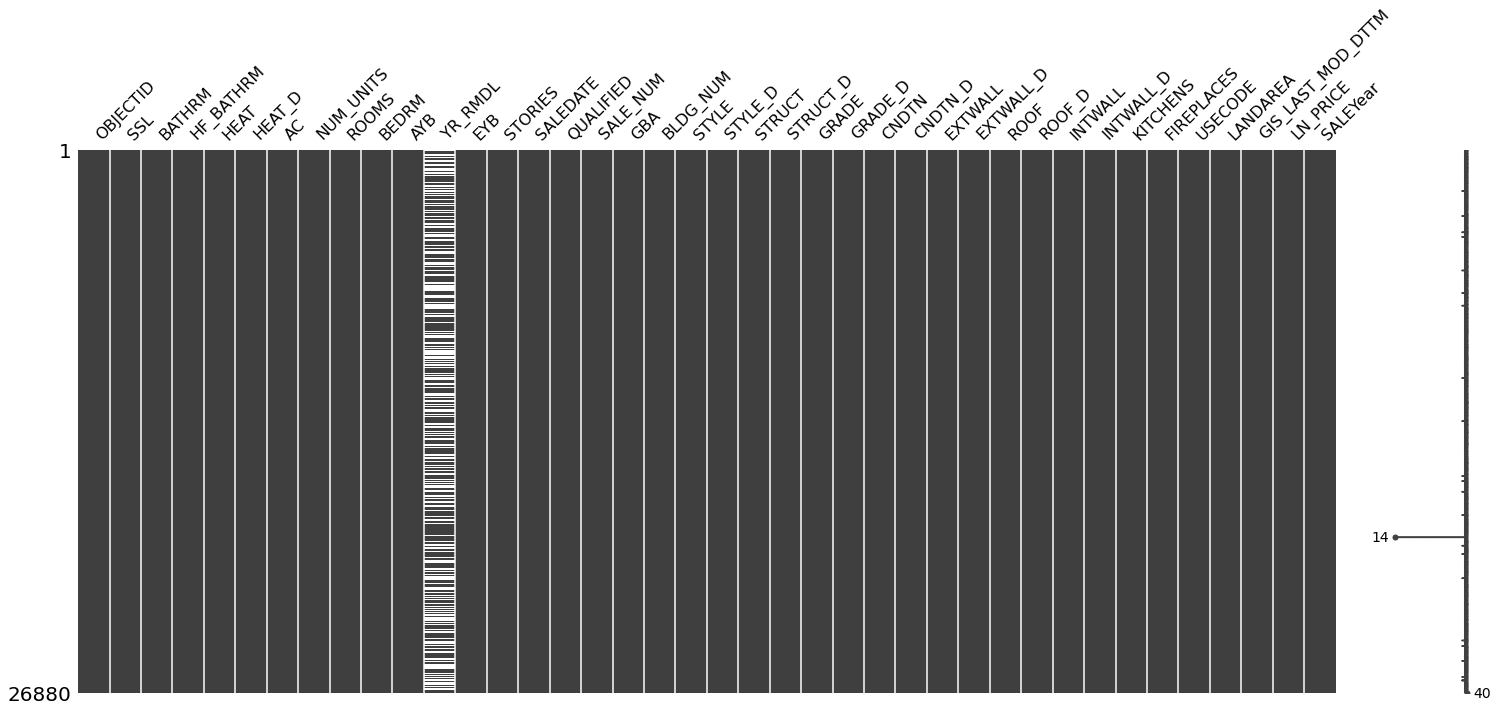

In [88]:
# the year of most recent sale is something we want to consider later as a predictor, we seperate it into a column
train_no_outliers['SALEYear'] = pd.to_datetime(train_no_outliers["SALEDATE"]).dt.year
# Look at missingness in the training data
miss.matrix(train_no_outliers)

### Clean the training data, split the predictors and outcome, and pre-process

In [89]:
# only keep those logged prices are not zero
train_no = train_no_outliers[train_no_outliers.LN_PRICE != 0]
test = test[test.LN_PRICE != 0]

# only keep those observations where the land area is not 0
train_no = train_no[train_no["LANDAREA"] != 0]
test = test[test.LANDAREA != 0]

# drops the Object ID and year remodeled column 
train_no = train_no.drop(["OBJECTID","YR_RMDL"], axis = 1)
test = test.drop(["OBJECTID","YR_RMDL"], axis = 1)

# change zeros to NAs in AC column (in both training and test data)
train_no['AC']=train_no['AC'].replace(0, np.nan)
test['AC']=test['AC'].replace(0, np.nan)

# Change AC from Y or N to 1 or 0
train_no["AC"] = np.where(train_no["AC"] == "Y", 1, 0)
test['AC']=np.where(test["AC"] == "Y", 1, 0)

# drop any values with NA
train_no = train_no.dropna()
test=test.dropna()

In selecting predictors, after reading each variable's description, I selected 11 most relevant features in my opinion. They are BATHRM (number of bathrooms), AC (air conditioning in residence), BEDRM (number of bedrooms), EYB (year of the most recent improvement), GBA (gross building area in square feet), GRADE, FIREPLACES (number of fireplaces), CNDTN (condition code), LANDAREA (land area of property), SALEYear (year of most recent sale), and SALE_NUM (sale number).

In [90]:
# set outcome: log selling price 
train_y = train_no["LN_PRICE"]
test_y = test["LN_PRICE"]

# select predictor variables we will consider for this analysis
train_X = train_no[["BATHRM", "AC", "BEDRM", "EYB", "GBA", "GRADE", 'FIREPLACES', "CNDTN", "LANDAREA", "SALEYear", "SALE_NUM"]]

# in test data, also seperate year of most recent sale into a column
test['SALEYear'] = pd.to_datetime(test["SALEDATE"]).dt.year
test_X = test[["BATHRM", "AC", "BEDRM", "EYB", "GBA", "GRADE", 'FIREPLACES', "CNDTN", "LANDAREA", "SALEYear", "SALE_NUM"]]

In [91]:
# rescale our training data for now, but we'll put the preprocessing into a modeling pipeline later on
scaler = pp.MinMaxScaler()
col_names = list(train_X)
train_X = scaler.fit_transform(train_X)

# Convert back into data frame
train_X = pd.DataFrame(train_X,columns=col_names)
train_X

,BATHRM,AC,BEDRM,EYB,GBA,GRADE,FIREPLACES,CNDTN,LANDAREA,SALEYear,SALE_NUM
0,0.428571,1.0,0.500,0.455556,0.104513,0.363636,0.000000,0.833333,0.108705,0.972222,0.142857
1,0.285714,1.0,0.375,0.488889,0.126419,0.454545,0.166667,0.833333,0.195755,0.333333,0.000000
2,0.142857,1.0,0.375,0.266667,0.106888,0.181818,0.000000,0.500000,0.135908,0.916667,0.071429
3,0.285714,0.0,0.500,0.244444,0.325680,0.363636,0.000000,0.500000,0.101325,0.916667,0.071429
4,0.428571,1.0,0.625,0.933333,0.345738,0.272727,0.000000,0.666667,0.282590,0.750000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
26847,0.142857,1.0,0.375,0.433333,0.093428,0.272727,0.166667,0.666667,0.032805,0.722222,0.000000
26848,0.142857,0.0,0.375,0.288889,0.140934,0.181818,0.000000,0.500000,0.086619,0.805556,0.000000
26849,0.285714,0.0,0.375,0.400000,0.124043,0.181818,0.000000,0.666667,0.211108,0.750000,0.000000
26850,0.142857,1.0,0.250,0.322222,0.066772,0.272727,0.166667,0.500000,0.018530,0.972222,0.285714


### Set up cross-validation and run the models
The problem that we're working on is a regression problem, we use the following models to try tackle the problem and make predictions

- Linear Regression
- KNN
- Decision Trees
- Bagging
- Random Forest

In [92]:
# use K-fold cross-validation to estimate the test error
fold_generator = KFold(n_splits=5, shuffle=True, random_state=111) # use the same data splits for each fold

In [93]:
# use mean squared error as our performance metrics
use_metrics = ["neg_mean_squared_error"]

# run Linear Model and calculate perforamnce score
lm_scores = cross_validate(LM(),train_X,train_y, cv = fold_generator, scoring =use_metrics)

# run KNN and calculate perforamnce score
knn_scores = cross_validate(KNN(),train_X,train_y, cv = fold_generator, scoring =use_metrics)

# run Decision Trees and calculate perforamnce score
dt_scores = cross_validate(DTree(),train_X,train_y, cv = fold_generator, scoring =use_metrics)

# run Bagging and calculate perforamnce score
bag_scores = cross_validate(Bag(),train_X,train_y, cv = fold_generator, scoring =use_metrics)

# run Random Forest and calculate perforamnce score
rf_scores = cross_validate(RF(),train_X,train_y, cv = fold_generator, scoring =use_metrics)

### Compare model performances

In [94]:
# collect all the metrics as a dictionary 
collect_scores = \
dict(lm = lm_scores['test_neg_mean_squared_error']*-1,
     knn = knn_scores['test_neg_mean_squared_error']*-1,
     dt = dt_scores['test_neg_mean_squared_error']*-1,
     bag = bag_scores['test_neg_mean_squared_error']*-1,
     rf = rf_scores['test_neg_mean_squared_error']*-1)

# Convert to a data frame and reshape
collect_scores = pd.DataFrame(collect_scores).melt(var_name="Model",value_name="Mean_squared_error")
collect_scores

,Model,Mean_squared_error
0,lm,0.224621
1,lm,0.213468
2,lm,0.195408
3,lm,0.200368
4,lm,0.203702
5,knn,0.197926
6,knn,0.192491
7,knn,0.173995
8,knn,0.184678
9,knn,0.182271


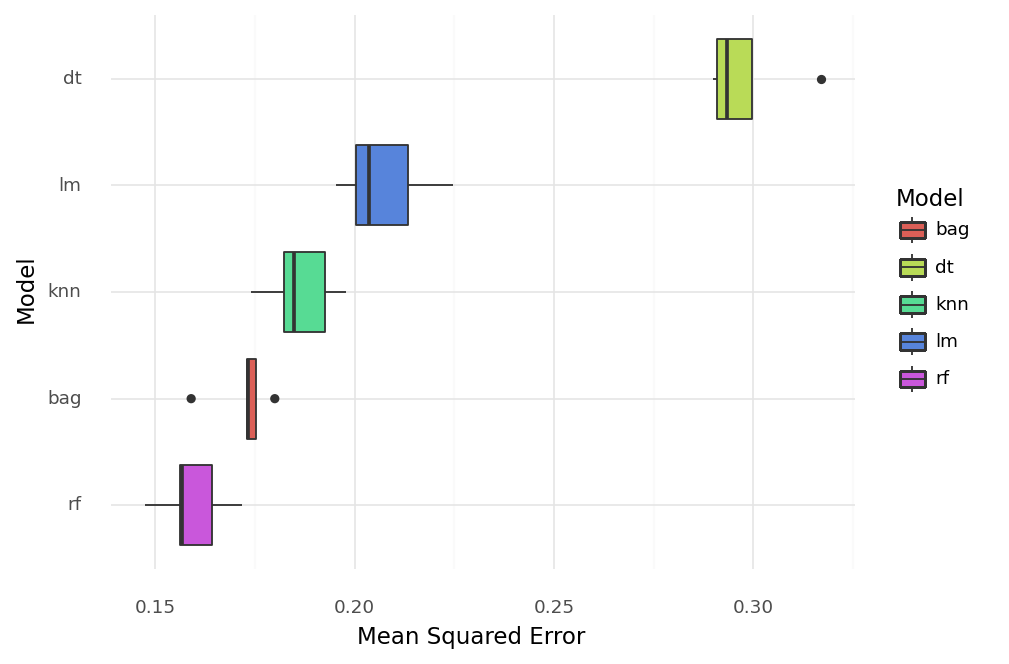

<ggplot: (299983972)>

In [95]:
# Order the models
order = (collect_scores.groupby('Model').mean().sort_values(by="Mean_squared_error").index.tolist())

# Plot the performance of the models in terms of MSE distribution
(
    ggplot(collect_scores,
          aes(x="Model",y="Mean_squared_error", fill="Model")) +
    geom_boxplot() +
    scale_x_discrete(limits=order) +
    labs(x="Model",y="Mean Squared Error") +
    coord_flip() +
    theme_minimal() +
    theme(dpi=150)
)

According to the plot above, the random forest model has the best performance, and bagging has the second best predictions. Noticably, the random forest, bagging, and K-nearest-neighbors all have MSE between 0.15 to 0.2, reflecting good performances generally. With an average MSE of 0.298, the decision tree model's performance is less satisfactory.

### Tuning Pipeline
We can piece together all the tuning steps, including preprocessing, specifying tuning parameters and GridSearch, as one seamless pipeline.

In [96]:
# (1) Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits=5, shuffle=True, random_state=111)

# (2) Next specify the preprocessing steps
preprocess = ColumnTransformer(transformers=[('num', pp.MinMaxScaler(), ["BATHRM", "AC", "BEDRM", "EYB", "GBA", "GRADE", 
                                                                         'FIREPLACES', "CNDTN", "LANDAREA", "SALEYear", "SALE_NUM"])])


# (3) Next Let's create our model pipe (note for the model we leave none as a placeholder)
pipe = Pipeline(steps=[('pre_process', preprocess),
                       ('model',None)])


# (4) Specify the models and their repsective tuning parameters. 
# Note the naming convention here to reference the model key
search_space = [
    # Linear Model
    {'model' : [LM()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[5,10,20,30,40,50]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DTree()],
     'model__max_depth':[1,2,3,4,5]},
    
    # The Bagging decision tree model 
    {'model': [Bag()]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
     'model__max_depth':[1,2,3],
     'model__n_estimators':[100, 500,1000,1250]},
]


# (5) Put it all together in the grid search
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='neg_mean_squared_error',
                      n_jobs=4)

# (6) Fit the model to the training data
search.fit(train_X,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=True),
             estimator=Pipeline(steps=[('pre_process',
                                        ColumnTransformer(transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         ['BATHRM',
                                                                          'AC',
                                                                          'BEDRM',
                                                                          'EYB',
                                                                          'GBA',
                                                                          'GRADE',
                                                                          'FIREPLACES',
                                                                          'CNDTN',
                                              

In [97]:
#  look at the best fit score from the scan
print("The best fit score is " + str(search.best_score_)) # Mean out-of-sample (CV) error


# look at the best model
print("The best model is " + str(search.best_params_))

The best fit score is -0.1726273872170401
The best model is {'model': BaggingRegressor()}


### Model performances on test data
Let's now see how well our best model does on the test data that it wasn't trained on.

In [98]:
# rescale our training data
scaler = pp.MinMaxScaler()
col_names = list(test_X)
test_X = scaler.fit_transform(test_X)

# Convert back into data frame
test_X = pd.DataFrame(test_X,columns=col_names)

# Predict() method will use the best model out of the scan
pred_y = search.predict(test_X)

In [99]:
# check mean_squared_error
m.mean_squared_error(test_y,pred_y)

0.4598763545105856

In [101]:
# check r-squared
m.r2_score(test_y,pred_y)

0.37765507163344414

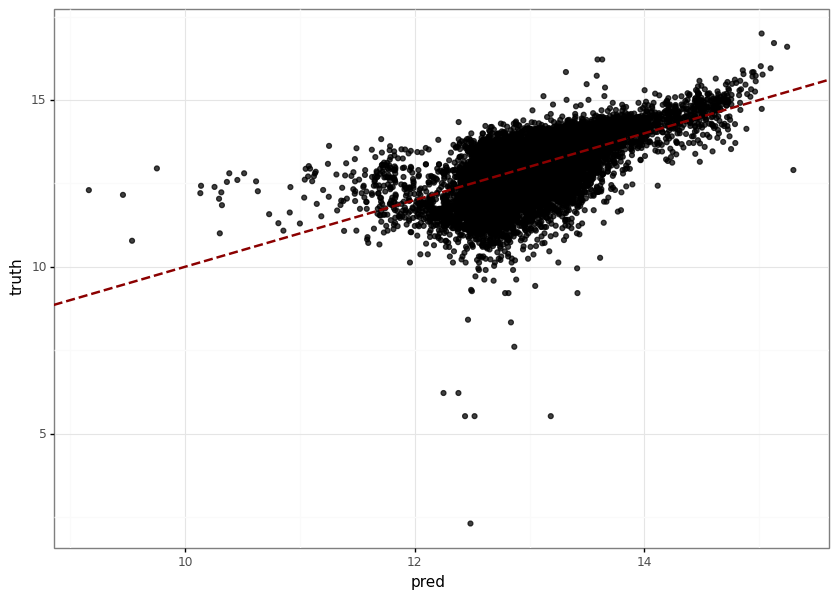

<ggplot: (299984086)>

In [102]:
# visualize the model accuracy
(
    ggplot(pd.DataFrame(dict(pred=pred_y,truth=test_y)),
          aes(x='pred',y="truth")) +
    geom_point(alpha=.75) +
    geom_abline(linetype="dashed",color="darkred",size=1) +
    theme_bw() +
    theme(figure_size=(10,7))
)